In [30]:

import pandas as pd
#graphing setup
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import countrycodes
import numpy as np

In [2]:

from sklearn import cross_validation
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB

C:\Users\schro\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


                                user_id  cycle_id cycle_start  cycle_length  \
0  11d912b0-5805-423b-94c5-152666db6979         1  2016-07-09          32.0   
1  11d912b0-5805-423b-94c5-152666db6979         2  2016-06-11          28.0   
2  11d912b0-5805-423b-94c5-152666db6979         4  2016-04-21          26.0   
3  11d912b0-5805-423b-94c5-152666db6979         5  2016-03-17          35.0   
4  11d912b0-5805-423b-94c5-152666db6979         6  2016-02-15          31.0   

   period_length  expected_cycle_length  
0            3.0                   30.0  
1            3.0                   29.0  
2            5.0                   29.0  
3            4.0                   29.0  
4            6.0                   30.0  


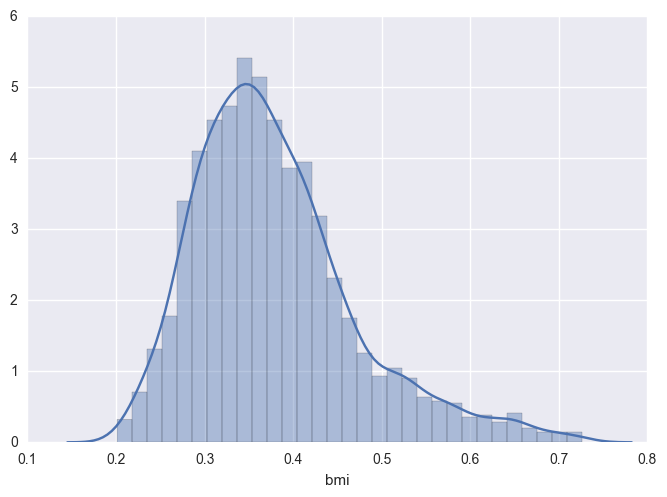

In [20]:
#load csv files
tracking_full=pd.read_csv(r'C:\Users\schro\Desktop\Projects\ClueWattx\cluehackathon\sample\tracking.csv')

symptoms = ['happy', 'pms', 'sad', 'sensitive_emotion', 'energized', 'exhausted',
                'high_energy', 'low_energy', 'cramps', 'headache', 'ovulation_pain',
                'tender_breasts', 'acne_skin', 'good_skin', 'oily_skin', 'dry_skin']
tracking = tracking_full[tracking_full.symptom.isin(symptoms)]
    
users=pd.read_csv(r'C:\Users\schro\Desktop\Projects\ClueWattx\cluehackathon\demo_data\users.csv')
cycles=pd.read_csv(r'C:\Users\schro\Desktop\Projects\ClueWattx\cluehackathon\demo_data\cycles.csv')
active_days=pd.read_csv(r'C:\Users\schro\Desktop\Projects\ClueWattx\cluehackathon\demo_data\active_days.csv')
cycles0=pd.read_csv(r'C:\Users\schro\Desktop\Projects\ClueWattx\cluehackathon\demo_data\cycles0.csv')
users['bmi']=users['weight']/users['height']
#sns.distplot(tracking['symptom'])
sns.distplot(users['bmi'][~np.isnan(users['bmi'])])

frames=[tracking,users,cycles]

full_set=pd.concat(frames, axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)

print cycles.head()




In [4]:
#distribution of users in different countries
country_dic= users['country'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)
print country_dic['France']

174


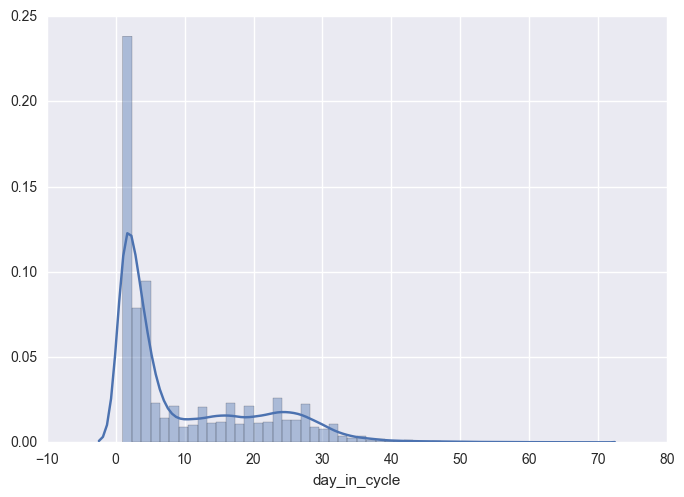

In [5]:
sns.distplot(active_days['day_in_cycle'][~np.isnan(active_days['day_in_cycle'])])

In [6]:
#create axis
#fig, axbox = plt.subplots()
#create boxplot
#print(tracking['day_in_cycle'])
#print tracking.head()
#sns.distplot(tracking['symptom'])
#sns.distplot(active_days['day_in_cycle'][~np.isnan(active_days['day_in_cycle'])])
#sns.boxplot(x='symptom', y='day_in_cycle'[~np.isnan(tracking['day_in_cycle'])], orient='h', data=tracking)
#axbox.set_ylabel('')
#axbox.set_yticklabels(['Passengers Lost','Passengers Survived'])

In [7]:
#Official scoring will be use a log loss formula. The same formula can be used for optimization
from sklearn.metrics import log_loss

In [69]:
def df_crossjoin(df1, df2, **kwargs):
    """
    Make a cross join (cartesian product) between two dataframes by using a constant temporary key.
    Also sets a MultiIndex which is the cartesian product of the indices of the input dataframes.
    See: https://github.com/pydata/pandas/issues/5401
    :param df1 dataframe 1
    :param df1 dataframe 2
    :param kwargs keyword arguments that will be passed to pd.merge()
    :return cross join of df1 and df2
    """
    df1['_tmpkey'] = 1
    df2['_tmpkey'] = 1

    res = pd.merge(df1, df2, on='_tmpkey', **kwargs).drop('_tmpkey', axis=1)
    res.index = pd.MultiIndex.from_product((df1.index, df2.index))

    df1.drop('_tmpkey', axis=1, inplace=True)
    df2.drop('_tmpkey', axis=1, inplace=True)

    return res

df_days = pd.DataFrame()
df_days['day_in_cycle'] = list(range(1,70))
df_raw = df_crossjoin(df_days, cycles0, suffixes=('_days', '_cycles'))
df_raw = df_raw[df_raw['day_in_cycle'] <= df_raw['expected_cycle_length']]
df_raw=df_raw.reset_index(drop=True)
df_raw[df_raw['user_id']=='11d912b0-5805-423b-94c5-152666db6979']

symptoms = ['happy', 'pms', 'sad', 'sensitive_emotion', 'energized', 'exhausted',
                'high_energy', 'low_energy', 'cramps', 'headache', 'ovulation_pain',
                'tender_breasts', 'acne_skin', 'good_skin', 'oily_skin', 'dry_skin']

#df_raw['symptoms']=symptoms
symptoms_df=pd.DataFrame(symptoms,columns=['symptom'])

df_raw_s = df_crossjoin(df_raw, symptoms_df)
#print df_raw_s.iloc[0:300,:]
#print df_raw_s.head()

df_raw_cyc= pd.merge(df_raw_s, tracking, how='left', on=['user_id', 'day_in_cycle', 'symptom'],sort=True)
print tracking.head()
print df_raw_s.head()
print df_raw_cyc.iloc[0:300,:]
del df_raw_cyc['cycle_id_x']
#df_raw_cyc=df_raw_cyc.drop(['cycle_id_x','cycle_start','date'])
#print df_raw_cyc.info()
#print df_raw_s.info()
#print tracking.info()


                                 user_id  cycle_id  day_in_cycle        date  \
2   e866e51b-d95d-4a47-879c-c7f0c8f7bdff         7            16  2016-03-05   
8   e866e51b-d95d-4a47-879c-c7f0c8f7bdff         7            16  2016-03-05   
9   e866e51b-d95d-4a47-879c-c7f0c8f7bdff         7            22  2016-03-11   
10  e866e51b-d95d-4a47-879c-c7f0c8f7bdff         7            21  2016-03-10   
11  e866e51b-d95d-4a47-879c-c7f0c8f7bdff         7            22  2016-03-11   

   category            symptom  
2      skin          oily_skin  
8    energy        high_energy  
9    energy          exhausted  
10   energy          exhausted  
11  emotion  sensitive_emotion  
     day_in_cycle                               user_id  cycle_id cycle_start  \
0 0             1  11d912b0-5805-423b-94c5-152666db6979         0  2016-08-10   
  1             1  11d912b0-5805-423b-94c5-152666db6979         0  2016-08-10   
  2             1  11d912b0-5805-423b-94c5-152666db6979         0  2016-08-10 

In [11]:
indexes=0
for x in cycles0['expected_cycle_length']:
    indexes+=x
    indexes=int(indexes)

print(indexes)
final=pd.DataFrame(data=cycles0, columns=['day','c1','c2','c3','label'], dtype=None, copy=False)

symptoms = ['happy', 'pms', 'sad', 'sensitive_emotion', 'energized', 'exhausted',
                'high_energy', 'low_energy', 'cramps', 'headache', 'ovulation_pain',
                'tender_breasts', 'acne_skin', 'good_skin', 'oily_skin', 'dry_skin']
ind=0
'''
while ind<indexes:
    day_count=0
    cycle_row=0
    for name in cycles0['user_id']:
        
        #add userid from cycles0 to final dataframe
        final.at[ind,'user']=name
        while day_count<cycles0['expected_cycle_length'][cycle_row]:
            final.at[ind,'day']=day_count
            day_count+=1
        cycle_row+=1
        for symp in symptoms:
            #add list of symptoms to each day
            final.at[ind,'symptom']=symp
            final.at[ind,'day']=day_count
            final.at[ind,'user']=name
            ind+=1

print(final.head())
print indexes
#final_len=len(cycles0)
'''


83896
    day  c1  c2  c3  label                                  user  \
0  30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
1  30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
2  30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
3  30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
4  30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   

             symptom  
0              happy  
1                pms  
2                sad  
3  sensitive_emotion  
4          energized  
83896


In [17]:
print final.iloc[0:500,0:]

      day  c1  c2  c3  label                                  user  \
0    30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
1    30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
2    30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
3    30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
4    30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
5    30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
6    30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
7    30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
8    30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
9    30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
10   30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
11   30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
12   30.0 NaN NaN NaN    NaN  11d912b0-5805-423b-94c5-152666db6979   
13   30.0 NaN NaN Na

In [ ]:
final_cycle=final


In [18]:
import sys
import pandas as pd

def run(data_fname):

    # load data
    df = pd.read_csv(data_fname)
    
    # extract symptoms we're interested in to predict
    symptoms = ['happy', 'pms', 'sad', 'sensitive_emotion', 'energized', 'exhausted',
                'high_energy', 'low_energy', 'cramps', 'headache', 'ovulation_pain',
                'tender_breasts', 'acne_skin', 'good_skin', 'oily_skin', 'dry_skin']
    cycles=[1.0,2.0,3.0]
    df = df[df.symptom.isin(symptoms)]
    df = df[df.cycle_id.isin(cycles)]

    # predictions are simply the averages per user/day_of_cycle/symptom of the training data
    #make df of users and cycles
    user_num_cycles = df[['user_id', 'cycle_id']].groupby(['user_id']).max()
    user_symptoms_total = df.groupby(['user_id', 'symptom', 'day_in_cycle']).count()[['cycle_id']]
    user_symptoms_rel = user_symptoms_total / user_num_cycles
   
    # create results
    user_symptoms_rel.reset_index(inplace=True)
    user_symptoms_rel = user_symptoms_rel.rename(columns={'cycle_id': 'probability'})
    results = user_symptoms_rel[['user_id', 'day_in_cycle', 'symptom', 'probability']]

    # save results in the correct format.
    results.to_csv(r'Desktop\Projects\ClueWattx\cluehackathon\example_submission_python\result2.txt', index=None)

tracking=r'C:\Users\schro\Desktop\Projects\ClueWattx\cluehackathon\demo_data\tracking.csv'

run(tracking)
'''
features_list=['country','birthyear','weight','height','platform','expected_cycle_length','day_in_cycle','symptom']
features_small=['birthyear','symptom']
features=(users[0],users[1])
#new features: day in cycle==day, bmi
labels=tracking[1]

clf=tree.DecisionTreeClassifier()

labels_train, labels_test, features_train, features_test=cross_validation.train_test_split(
labels,features,random_state=42,test_size=0.3)

#train and fit decision tree model to top 8 variables
clf.fit(features_train,labels_train)
poi_result=clf.predict(features_test, labels_test)
print poi_result
'''

                                user_id  cycle_id  day_in_cycle        date  \
0  8dc26057-635b-4bf6-8672-d7cc1a3a7b62         7            42  2016-03-14   
1  8dc26057-635b-4bf6-8672-d7cc1a3a7b62         7            37  2016-03-09   
2  8dc26057-635b-4bf6-8672-d7cc1a3a7b62         7            35  2016-03-07   
3  8dc26057-635b-4bf6-8672-d7cc1a3a7b62         7            32  2016-03-04   
4  8dc26057-635b-4bf6-8672-d7cc1a3a7b62         7            31  2016-03-03   

  category        symptom  
0    sleep            6-9  
1    sleep            6-9  
2    sleep            6-9  
3    sleep            6-9  
4  craving  carbs_craving  


"\nfeatures_list=['country','birthyear','weight','height','platform','expected_cycle_length','day_in_cycle','symptom']\nfeatures_small=['birthyear','symptom']\nfeatures=(users[0],users[1])\n#new features: day in cycle==day, bmi\nlabels=tracking[1]\n\nclf=tree.DecisionTreeClassifier()\n\nlabels_train, labels_test, features_train, features_test=cross_validation.train_test_split(\nlabels,features,random_state=42,test_size=0.3)\n\n#train and fit decision tree model to top 8 variables\nclf.fit(features_train,labels_train)\npoi_result=clf.predict(features_test, labels_test)\nprint poi_result\n"

In [ ]:
#use decision tree classifier
tree_clf=tree.DecisionTreeClassifier()
#select best features to use in pipeline
X_new = SelectKBest()
#build pipeline to pick kbest parameters and model with decision tree
pipe = Pipeline(steps=[("SKB", X_new),("Tree",tree_clf)])

parameters = {'SKB__k': [6,7,8], 'Tree__min_samples_split':[2,4,8],
              'Tree__max_depth':[None,1,2,3], 'Tree__splitter':['best', 'random'],
                'Tree__random_state':[41] }

#model using stratified shuffle split 
sss= StratifiedShuffleSplit(random_state = 42)
gs = GridSearchCV(pipe, parameters, scoring='logloss', cv=sss,verbose=10)
gs.fit(features_train, labels_train)


In [ ]:
#looking at descriptive statistics